In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import List, Tuple
import logging
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score
import seaborn as sns
import torch.nn.functional as F

In [2]:
def similarity_cosine(vec1, vec2):
    cosine_similarity_arr = []
    for v1,v2 in zip(vec1, vec2):
        cosine_similarity = np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))
        cosine_similarity_arr.append(cosine_similarity)
    return np.array(cosine_similarity_arr)

def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)
    return result

def update_co_occurrences(word_year_list,word_co_occurrences):
    # Iterate through the words in the list
    word_list, year = word_year_list
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)

### Get Word Co-Occurances

In [3]:
concept_filtered_arr = np.load("saved_files/overlapping_filtered_5_concepts.npy")
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
saved_year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

print("Concepts which were tracked",concept_filtered_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",saved_year_arr.shape)

phys_filtered_concept_dict = {k:1 for k in concept_filtered_arr}
ocurr_arr = []
for abstract, year in zip(ngram_abstracts, saved_year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in phys_filtered_concept_dict]
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])
                        
word_co_occurrences = {}

for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list,word_co_occurrences)

Concepts which were tracked (10235,)
Abstracts (66839,)
Year associated to abstract (66839,)


100%|██████████| 63633/63633 [00:02<00:00, 29878.70it/s]


### Get Embedding

In [4]:
# def load_model_for_year(year):
#     return Word2Vec.load(f"saved_models/re_model_year_{year}.model")

# load = True 
# if load:
c_inx_arr = np.memmap("saved_files/embedding_concept_arr.dat",shape=(10235,), dtype="<U55")
c_encoding_arr = np.memmap("saved_files/embedding_vector_arr.dat",shape=(10235, 30, 128), dtype=np.float64)

# else:
#     # Initialize dictionaries and counters
#     c_dict = {}
#     cnt_0, cnt_1 = 0, 0

#     # Get the unique years
#     unique_years = np.unique(saved_year_arr)

#     # Iterate over each year and load the corresponding model
#     for year in tqdm(unique_years):
#         loaded_w2v = load_model_for_year(year)

#         # Iterate over each concept in the filtered concept dictionary
#         for c in phys_filtered_concept_dict:
#             if c not in c_dict:
#                 c_dict[c] = {}

#             # If the concept is already recorded for the current year, skip it
#             if year in c_dict[c]:
#                 continue

#             try:
#                 # Get the vector encoding for the concept
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] = vec_enc
#                 cnt_0 += 1
#             except KeyError:  # Catch specific exception for missing key
#                 cnt_1 += 1
#                 pass

#     print(f"Found {cnt_0} vectors, missed {cnt_1} vectors.")

#     # Initialize lists for lengths and concept indices
#     len_arr, len_new_arr, concept_inx_arr = [], [], []

#     # Iterate over each concept to fill missing years with the first available vector
#     for c in tqdm(phys_filtered_concept_dict):
#         l = len(c_dict[c])
#         len_arr.append(l)

#         if l > 0:
#             concept_inx_arr.append(c)
#             success_years = sorted(c_dict[c].keys())
#             first_success_year = success_years[0]

#             # Backtrack and fill in the missing years with the first available vector
#             for year in unique_years:
#                 if year < first_success_year:
#                     if year not in c_dict[c]:
#                         c_dict[c][year] = c_dict[c][first_success_year]
#                 else:
#                     break

#         len_new_arr.append(len(c_dict[c]))

#     concept_inx_arr = np.array(concept_inx_arr)

#     # Display the distribution of the number of years filled for each concept
#     print(np.unique(len_new_arr, return_counts=True))

#     # Prepare the encoding array
#     num_concepts = len(c_dict)
#     num_years = len(unique_years)
#     embedding_dim = 128

#     c_encoding_arr = np.zeros((num_concepts, num_years, embedding_dim))
#     c_inx_arr = []

#     # Fill the encoding array with vectors for each concept and year
#     for cnt, (concept, year_vectors) in enumerate(c_dict.items()):
#         c_encoding_arr[cnt] = np.array([year_vectors.get(year, np.zeros(embedding_dim)) for year in unique_years])
#         c_inx_arr.append(concept)

#     c_inx_arr = np.array(c_inx_arr)

    
#     filename = 'saved_files/embedding_concept_arr.dat'
#     memmap_array = np.memmap(filename, dtype=c_inx_arr.dtype, mode='w+', shape=c_inx_arr.shape)
#     print("shape:",c_inx_arr.shape)
#     memmap_array[:] = c_inx_arr
#     memmap_array.flush()

#     filename = 'saved_files/embedding_vector_arr.dat'
#     memmap_array = np.memmap(filename, dtype=c_encoding_arr.dtype, mode='w+', shape=c_encoding_arr.shape)
#     print("shape:",c_encoding_arr.shape)
#     memmap_array[:] = c_encoding_arr
#     memmap_array.flush()

#     stop

### Create Dataset

In [5]:
def get_co_occur_concept_pair_after_year_arr(word_co_occurrences: dict, first_occ_year: int, final_occ_year: int) -> np.ndarray:
    co_occur_concept_pair_arr = []
    for concept, v in word_co_occurrences.items():
        for co_concept, years in v.items():
            if np.min(years) >= first_occ_year and np.max(years) <= final_occ_year:
                co_occur_concept_pair_arr.append([concept,co_concept])
    return np.array(co_occur_concept_pair_arr)

def _get_years_range(start: int, end: int) -> np.ndarray:
        return (np.unique(saved_year_arr)[start:] if end == -0 
                                 else np.unique(saved_year_arr)[start:end])

def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1, print_test: bool = False, save=True):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])
    
    print(f"Training Window: {_get_years_range(-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
    print(f"Label Window: {_get_years_range(-output_window_size-offset_to_current_year, -offset_to_current_year)}")



    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
        pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]

    print("Finished Positives")

    neg_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")

    if print_test:
        save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
        save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

        save_pos_arr = [x for xs in save_pos_arr for x in xs]
        
        print("Positive: Expect to be years: ", np.unique(save_pos_arr))
        print("Negative: Expect to be 0: ", np.sum(save_neg_arr))

    if save:
        np.save(f"saved_files/train_pos_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", pos_inx_pair_arr)
        np.save(f"saved_files/train_neg_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", neg_inx_pair_arr)

    return pos_inx_pair_arr, neg_inx_pair_arr




print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
print("Concept associted with representation", c_inx_arr.shape)
scaler = StandardScaler()
reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  
normalized_data = scaler.fit_transform(reshaped_data)
encoding_data = normalized_data.reshape(c_encoding_arr.shape)

# load = False 
# if not load:
    
# else:
# train_pos_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_3.npy")
# train_neg_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_3.npy")

# train_pos_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_0.npy")
# train_neg_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_0.npy")


Representation Vectors for tracked concepts (10235, 30, 128)
Concept associted with representation (10235,)


In [6]:
class CustomPairDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels, input_window_size, output_window_size, offset_to_current_year):
        self.train_window_data = train_window_data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32), inx_0, inx_1 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomPairDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx], input_window_size, output_window_size, offset_to_current_year)
    test_dataset = CustomPairDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx], input_window_size, output_window_size, offset_to_current_year)
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomPairDataset(train_window_data, all_pairs, all_labels, input_window_size, output_window_size, offset_to_current_year)

In [7]:
# # print(f"Training Window: {_get_years_range(-5-3-3, -3-3)}")
# # print(f"Label Window: {_get_years_range(-3-0, -0)}")

# input_window_size = 5
# output_window_size = 3
# offset_to_current_year = 3

# print(f"Training Window: {_get_years_range(-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
# print(f"Label Window: {_get_years_range(-output_window_size-offset_to_current_year, -offset_to_current_year)}")

# offset_to_current_year = 0

# print(f"Testing Window: {_get_years_range(-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
# print(f"Label Window: {_get_years_range(-output_window_size-offset_to_current_year, -offset_to_current_year)}")

In [8]:
# class NovelSeriesDataset(Dataset):
#     def __init__(self, data: np.ndarray, c_inx_arr: np.ndarray, input_window_size: int = 5):
#         """
#         Dataset for novel series data.

#         Args:
#             data (np.ndarray): The input data.
#             c_inx_arr (np.ndarray): Array of concept indices.
#             input_window_size (int, optional): Size of the input window. Defaults to 5.
#         """
#         self.train_window_data = data[:, -input_window_size:]
#         self.c_inx_arr = c_inx_arr
#         self.input_window_size = input_window_size

#     def __len__(self) -> int:
#         return 64 * 2000

#     def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
#         while True:
#             sampled_pair = np.random.choice(self.train_window_data.shape[0], size=2)
#             if self.c_inx_arr[sampled_pair[1]] not in word_co_occurrences[self.c_inx_arr[sampled_pair[0]]]:
#                 break
#         inx_0 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[0]])[0]
#         inx_1 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[1]])[0]
#         enc_0 = self.train_window_data[inx_0][0]
#         enc_1 = self.train_window_data[inx_1][0]
#         enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
#         return torch.from_numpy(enc_01), torch.from_numpy(np.array([inx_0, inx_1])), inx_0, inx_1

#     def _check_indexing(self):
#         print(f"Training Window: {np.unique(saved_year_arr)[-self.input_window_size:]}")

# novel_dataset = NovelSeriesDataset(data=encoding_data, c_inx_arr=c_inx_arr, input_window_size = seq_length)
# novel_dataset._check_indexing()
# novel_dataloader = DataLoader(novel_dataset, batch_size=batch_size, shuffle=True)

In [9]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

class MLP(nn.Module):
    def __init__(self, raw_size, drop=.25):
        super().__init__()
        
        self.raw = nn.Sequential(
            Flatten(),
            nn.Dropout(drop), nn.Linear(raw_size, 128), nn.PReLU(), nn.BatchNorm1d(128),
            nn.Dropout(drop), nn.Linear(128, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.output = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(inplace=True), nn.Linear(32, 1), nn.Sigmoid())
        

        
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.output(raw_out)
        return out

In [10]:
# Define the training and validation functions
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # for data, labels, _ in train_loader:
    for data, labels, _, _ in train_loader:
        
        optimizer.zero_grad()
        outputs = model(data.float())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    return train_loss, train_accuracy

def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, labels, _, _ in val_loader:
            
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy

# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7, file_name='saved_files/best_mlp_model.pth'):
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)

        scheduler.step()
        
        logging.info(f'Epoch [{epoch+1}/{num_epochs}], '
                     f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                     f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), file_name)
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                logging.info("Early stopping triggered")
                logging.info("Best model saved with {best_val_loss:.2f} accuracy")
                break



In [11]:
def compute_auc(model, dataloader, save=False):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, labels,_ ,_ in dataloader:
            outputs = model(data.float(), )
            probs = outputs.cpu().numpy()
            
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    if save:
        np.save("fpr_method.npy", fpr)
        np.save("tpr_method.npy", tpr)

    return fpr, tpr, roc_auc



def plot_roc(model, dataloader):
    
    fpr, tpr, roc_auc = compute_auc(model, dataloader)
    # Plot ROC curve
    plt.figure(figsize=(3.5, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
# model_mlp.load_state_dict(torch.load('saved_files/best_mlp_model.pth'))
# plot_roc(model_mlp, test_dataloader)

In [12]:
auc_arr = []
for seq_length in tqdm([1,2,3,4,5,6,7,8,9,10]):
    out_length = 3
    batch_size = 128

    train_pos_inx_pair_arr_5_3_3, train_neg_inx_pair_arr_5_3_3 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(saved_year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3, print_test=True)

    train_pos_inx_pair_arr_5_3_0, train_neg_inx_pair_arr_5_3_0 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(saved_year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0, print_test=True)



    train_dataset, val_dataset = create_train_val_datasets(
        train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_3, 
        input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 3, test_size=0.2)

    test_dataset = create_test_datasets(
        train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_0, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_0, 
        input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 0)


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Initialize logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Example usage
    input_dim = train_dataset.train_window_data.shape[1] * train_dataset.train_window_data.shape[2] * 2  
    model_mlp = MLP(input_dim)


    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler, file_name=f"saved_files/best_seq_{seq_length}_model.pth")
    model_mlp.load_state_dict(torch.load(f"saved_files/best_seq_{seq_length}_model.pth"))
    auc_arr.append(compute_auc(model_mlp, test_dataloader)[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

Training Window: [2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 13:40:35,991 - INFO - Epoch [1/50], Train Loss: 0.4953, Train Accuracy: 77.10%, Val Loss: 0.4696, Val Accuracy: 78.35%
2024-08-02 13:40:46,737 - INFO - Epoch [2/50], Train Loss: 0.4787, Train Accuracy: 78.11%, Val Loss: 0.4620, Val Accuracy: 78.83%
2024-08-02 13:40:57,301 - INFO - Epoch [3/50], Train Loss: 0.4718, Train Accuracy: 78.37%, Val Loss: 0.4557, Val Accuracy: 79.55%
2024-08-02 13:41:07,447 - INFO - Epoch [4/50], Train Loss: 0.4676, Train Accuracy: 78.52%, Val Loss: 0.4562, Val Accuracy: 79.19%
2024-08-02 13:41:17,657 - INFO - Epoch [5/50], Train Loss: 0.4634, Train Accuracy: 78.79%, Val Loss: 0.4507, Val Accuracy: 79.66%
2024-08-02 13:41:27,476 - INFO - Epoch [6/50], Train Loss: 0.4596, Train Accuracy: 79.00%, Val Loss: 0.4467, Val Accuracy: 79.68%
2024-08-02 13:41:37,644 - INFO - Epoch [7/50], Train Loss: 0.4567, Train Accuracy: 79.21%, Val Loss: 0.4430, Val Accuracy: 79.99%
2024-08-02 13:41:47,372 - INFO - Epoch [8/50], Train Loss: 0.4540, Train Accuracy: 79.35%,

Training Window: [2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 13:45:38,870 - INFO - Epoch [1/50], Train Loss: 0.4941, Train Accuracy: 77.15%, Val Loss: 0.4710, Val Accuracy: 78.27%
2024-08-02 13:45:49,910 - INFO - Epoch [2/50], Train Loss: 0.4760, Train Accuracy: 78.16%, Val Loss: 0.4657, Val Accuracy: 78.70%
2024-08-02 13:46:00,792 - INFO - Epoch [3/50], Train Loss: 0.4680, Train Accuracy: 78.65%, Val Loss: 0.4561, Val Accuracy: 79.20%
2024-08-02 13:46:12,230 - INFO - Epoch [4/50], Train Loss: 0.4630, Train Accuracy: 78.84%, Val Loss: 0.4544, Val Accuracy: 79.28%
2024-08-02 13:46:23,317 - INFO - Epoch [5/50], Train Loss: 0.4585, Train Accuracy: 79.09%, Val Loss: 0.4491, Val Accuracy: 79.61%
2024-08-02 13:46:35,744 - INFO - Epoch [6/50], Train Loss: 0.4538, Train Accuracy: 79.38%, Val Loss: 0.4495, Val Accuracy: 79.54%
2024-08-02 13:46:46,078 - INFO - Epoch [7/50], Train Loss: 0.4504, Train Accuracy: 79.49%, Val Loss: 0.4506, Val Accuracy: 79.46%
2024-08-02 13:46:57,160 - INFO - Epoch [8/50], Train Loss: 0.4467, Train Accuracy: 79.73%,

Training Window: [2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 13:49:52,085 - INFO - Epoch [1/50], Train Loss: 0.4929, Train Accuracy: 77.23%, Val Loss: 0.4694, Val Accuracy: 78.38%
2024-08-02 13:50:03,425 - INFO - Epoch [2/50], Train Loss: 0.4722, Train Accuracy: 78.42%, Val Loss: 0.4581, Val Accuracy: 78.92%
2024-08-02 13:50:13,905 - INFO - Epoch [3/50], Train Loss: 0.4638, Train Accuracy: 78.91%, Val Loss: 0.4534, Val Accuracy: 79.12%
2024-08-02 13:50:24,466 - INFO - Epoch [4/50], Train Loss: 0.4577, Train Accuracy: 79.25%, Val Loss: 0.4483, Val Accuracy: 79.62%
2024-08-02 13:50:36,369 - INFO - Epoch [5/50], Train Loss: 0.4525, Train Accuracy: 79.44%, Val Loss: 0.4472, Val Accuracy: 79.84%
2024-08-02 13:50:48,575 - INFO - Epoch [6/50], Train Loss: 0.4481, Train Accuracy: 79.66%, Val Loss: 0.4412, Val Accuracy: 80.08%
2024-08-02 13:51:00,584 - INFO - Epoch [7/50], Train Loss: 0.4437, Train Accuracy: 79.92%, Val Loss: 0.4425, Val Accuracy: 80.11%
2024-08-02 13:51:14,585 - INFO - Epoch [8/50], Train Loss: 0.4401, Train Accuracy: 80.06%,

Training Window: [2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 13:55:22,766 - INFO - Epoch [1/50], Train Loss: 0.4928, Train Accuracy: 77.26%, Val Loss: 0.4716, Val Accuracy: 78.47%
2024-08-02 13:55:37,032 - INFO - Epoch [2/50], Train Loss: 0.4732, Train Accuracy: 78.39%, Val Loss: 0.4701, Val Accuracy: 78.59%
2024-08-02 13:55:50,571 - INFO - Epoch [3/50], Train Loss: 0.4643, Train Accuracy: 78.89%, Val Loss: 0.4587, Val Accuracy: 79.13%
2024-08-02 13:56:03,719 - INFO - Epoch [4/50], Train Loss: 0.4582, Train Accuracy: 79.14%, Val Loss: 0.4482, Val Accuracy: 79.60%
2024-08-02 13:56:17,249 - INFO - Epoch [5/50], Train Loss: 0.4525, Train Accuracy: 79.46%, Val Loss: 0.4475, Val Accuracy: 79.81%
2024-08-02 13:56:30,452 - INFO - Epoch [6/50], Train Loss: 0.4476, Train Accuracy: 79.76%, Val Loss: 0.4428, Val Accuracy: 79.89%
2024-08-02 13:56:42,965 - INFO - Epoch [7/50], Train Loss: 0.4422, Train Accuracy: 79.93%, Val Loss: 0.4416, Val Accuracy: 79.95%
2024-08-02 13:56:55,298 - INFO - Epoch [8/50], Train Loss: 0.4386, Train Accuracy: 80.13%,

Training Window: [2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:01:08,692 - INFO - Epoch [1/50], Train Loss: 0.4927, Train Accuracy: 77.31%, Val Loss: 0.4685, Val Accuracy: 78.61%
2024-08-02 14:01:21,377 - INFO - Epoch [2/50], Train Loss: 0.4708, Train Accuracy: 78.55%, Val Loss: 0.4553, Val Accuracy: 79.18%
2024-08-02 14:01:33,511 - INFO - Epoch [3/50], Train Loss: 0.4607, Train Accuracy: 79.11%, Val Loss: 0.4519, Val Accuracy: 79.33%
2024-08-02 14:01:47,319 - INFO - Epoch [4/50], Train Loss: 0.4540, Train Accuracy: 79.42%, Val Loss: 0.4515, Val Accuracy: 79.25%
2024-08-02 14:01:59,818 - INFO - Epoch [5/50], Train Loss: 0.4478, Train Accuracy: 79.74%, Val Loss: 0.4420, Val Accuracy: 79.85%
2024-08-02 14:02:13,482 - INFO - Epoch [6/50], Train Loss: 0.4418, Train Accuracy: 80.04%, Val Loss: 0.4390, Val Accuracy: 80.09%
2024-08-02 14:02:29,317 - INFO - Epoch [7/50], Train Loss: 0.4370, Train Accuracy: 80.25%, Val Loss: 0.4376, Val Accuracy: 80.13%
2024-08-02 14:02:43,766 - INFO - Epoch [8/50], Train Loss: 0.4331, Train Accuracy: 80.46%,

Training Window: [2012 2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2015 2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:06:39,768 - INFO - Epoch [1/50], Train Loss: 0.4938, Train Accuracy: 77.17%, Val Loss: 0.4688, Val Accuracy: 78.51%
2024-08-02 14:06:56,929 - INFO - Epoch [2/50], Train Loss: 0.4710, Train Accuracy: 78.52%, Val Loss: 0.4591, Val Accuracy: 79.32%
2024-08-02 14:07:13,192 - INFO - Epoch [3/50], Train Loss: 0.4607, Train Accuracy: 78.97%, Val Loss: 0.4482, Val Accuracy: 79.67%
2024-08-02 14:07:30,394 - INFO - Epoch [4/50], Train Loss: 0.4534, Train Accuracy: 79.50%, Val Loss: 0.4450, Val Accuracy: 79.84%
2024-08-02 14:07:47,256 - INFO - Epoch [5/50], Train Loss: 0.4472, Train Accuracy: 79.82%, Val Loss: 0.4427, Val Accuracy: 80.05%
2024-08-02 14:08:03,893 - INFO - Epoch [6/50], Train Loss: 0.4425, Train Accuracy: 79.96%, Val Loss: 0.4398, Val Accuracy: 80.21%
2024-08-02 14:08:19,312 - INFO - Epoch [7/50], Train Loss: 0.4369, Train Accuracy: 80.28%, Val Loss: 0.4386, Val Accuracy: 80.38%
2024-08-02 14:08:32,801 - INFO - Epoch [8/50], Train Loss: 0.4323, Train Accuracy: 80.59%,

Training Window: [2011 2012 2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2014 2015 2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:12:53,700 - INFO - Epoch [1/50], Train Loss: 0.4949, Train Accuracy: 77.25%, Val Loss: 0.4622, Val Accuracy: 78.85%
2024-08-02 14:13:07,921 - INFO - Epoch [2/50], Train Loss: 0.4712, Train Accuracy: 78.52%, Val Loss: 0.4565, Val Accuracy: 79.35%
2024-08-02 14:13:21,890 - INFO - Epoch [3/50], Train Loss: 0.4602, Train Accuracy: 79.06%, Val Loss: 0.4506, Val Accuracy: 79.45%
2024-08-02 14:13:36,235 - INFO - Epoch [4/50], Train Loss: 0.4528, Train Accuracy: 79.49%, Val Loss: 0.4447, Val Accuracy: 79.82%
2024-08-02 14:13:49,815 - INFO - Epoch [5/50], Train Loss: 0.4457, Train Accuracy: 79.76%, Val Loss: 0.4420, Val Accuracy: 80.03%
2024-08-02 14:14:04,079 - INFO - Epoch [6/50], Train Loss: 0.4401, Train Accuracy: 80.12%, Val Loss: 0.4385, Val Accuracy: 80.26%
2024-08-02 14:14:18,917 - INFO - Epoch [7/50], Train Loss: 0.4350, Train Accuracy: 80.34%, Val Loss: 0.4363, Val Accuracy: 80.38%
2024-08-02 14:14:33,358 - INFO - Epoch [8/50], Train Loss: 0.4301, Train Accuracy: 80.68%,

Training Window: [2010 2011 2012 2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2013 2014 2015 2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:18:25,229 - INFO - Epoch [1/50], Train Loss: 0.4954, Train Accuracy: 77.06%, Val Loss: 0.4641, Val Accuracy: 78.69%
2024-08-02 14:18:39,846 - INFO - Epoch [2/50], Train Loss: 0.4700, Train Accuracy: 78.49%, Val Loss: 0.4567, Val Accuracy: 79.29%
2024-08-02 14:18:54,871 - INFO - Epoch [3/50], Train Loss: 0.4595, Train Accuracy: 79.10%, Val Loss: 0.4479, Val Accuracy: 79.76%
2024-08-02 14:19:09,754 - INFO - Epoch [4/50], Train Loss: 0.4517, Train Accuracy: 79.49%, Val Loss: 0.4454, Val Accuracy: 79.88%
2024-08-02 14:19:24,405 - INFO - Epoch [5/50], Train Loss: 0.4441, Train Accuracy: 79.95%, Val Loss: 0.4418, Val Accuracy: 80.21%
2024-08-02 14:19:39,186 - INFO - Epoch [6/50], Train Loss: 0.4378, Train Accuracy: 80.21%, Val Loss: 0.4374, Val Accuracy: 80.31%
2024-08-02 14:19:54,349 - INFO - Epoch [7/50], Train Loss: 0.4327, Train Accuracy: 80.46%, Val Loss: 0.4331, Val Accuracy: 80.48%
2024-08-02 14:20:08,722 - INFO - Epoch [8/50], Train Loss: 0.4274, Train Accuracy: 80.69%,

Training Window: [2009 2010 2011 2012 2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2012 2013 2014 2015 2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:24:27,760 - INFO - Epoch [1/50], Train Loss: 0.4936, Train Accuracy: 77.25%, Val Loss: 0.4695, Val Accuracy: 78.45%
2024-08-02 14:24:44,262 - INFO - Epoch [2/50], Train Loss: 0.4700, Train Accuracy: 78.54%, Val Loss: 0.4603, Val Accuracy: 79.11%
2024-08-02 14:25:03,823 - INFO - Epoch [3/50], Train Loss: 0.4581, Train Accuracy: 79.29%, Val Loss: 0.4514, Val Accuracy: 79.44%
2024-08-02 14:25:25,580 - INFO - Epoch [4/50], Train Loss: 0.4506, Train Accuracy: 79.64%, Val Loss: 0.4462, Val Accuracy: 79.87%
2024-08-02 14:25:41,980 - INFO - Epoch [5/50], Train Loss: 0.4431, Train Accuracy: 79.96%, Val Loss: 0.4442, Val Accuracy: 79.98%
2024-08-02 14:26:00,116 - INFO - Epoch [6/50], Train Loss: 0.4366, Train Accuracy: 80.29%, Val Loss: 0.4383, Val Accuracy: 80.13%
2024-08-02 14:26:19,070 - INFO - Epoch [7/50], Train Loss: 0.4304, Train Accuracy: 80.67%, Val Loss: 0.4357, Val Accuracy: 80.29%
2024-08-02 14:26:38,881 - INFO - Epoch [8/50], Train Loss: 0.4264, Train Accuracy: 80.83%,

Training Window: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


2024-08-02 14:31:57,009 - INFO - Epoch [1/50], Train Loss: 0.4945, Train Accuracy: 77.10%, Val Loss: 0.4702, Val Accuracy: 78.41%
2024-08-02 14:32:12,573 - INFO - Epoch [2/50], Train Loss: 0.4693, Train Accuracy: 78.61%, Val Loss: 0.4579, Val Accuracy: 79.35%
2024-08-02 14:32:28,236 - INFO - Epoch [3/50], Train Loss: 0.4581, Train Accuracy: 79.16%, Val Loss: 0.4476, Val Accuracy: 79.70%
2024-08-02 14:32:43,701 - INFO - Epoch [4/50], Train Loss: 0.4499, Train Accuracy: 79.61%, Val Loss: 0.4455, Val Accuracy: 80.05%
2024-08-02 14:32:59,415 - INFO - Epoch [5/50], Train Loss: 0.4417, Train Accuracy: 80.05%, Val Loss: 0.4385, Val Accuracy: 80.26%
2024-08-02 14:33:15,117 - INFO - Epoch [6/50], Train Loss: 0.4346, Train Accuracy: 80.41%, Val Loss: 0.4346, Val Accuracy: 80.44%
2024-08-02 14:33:31,012 - INFO - Epoch [7/50], Train Loss: 0.4288, Train Accuracy: 80.72%, Val Loss: 0.4341, Val Accuracy: 80.61%
2024-08-02 14:33:46,604 - INFO - Epoch [8/50], Train Loss: 0.4239, Train Accuracy: 81.05%,

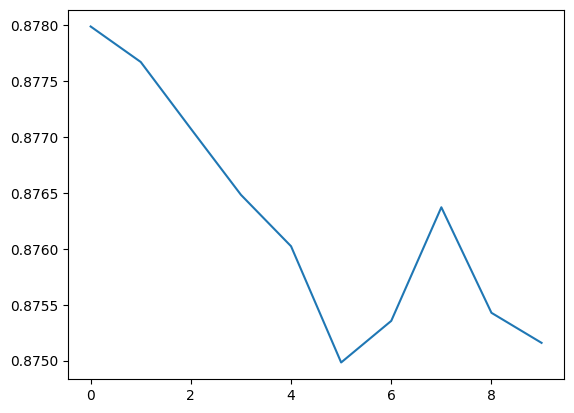

In [15]:
plt.plot(auc_arr)

In [ ]:
# def plot_top_n(model, dataloader):
#     model.eval()
#     all_precision = []
#     all_rand_precision = []
#     with torch.no_grad():
#         for data, labels,_ ,_ in dataloader:
#             outputs = model(data.float(), )

#             predicted = (outputs > 0.5).float()
#             precision_ = precision_score(labels,predicted)
            
#             all_precision.extend([precision_])
#             precision_rand = precision_score(labels,np.random.randint(0,2,len(predicted)))
#             all_rand_precision.extend([precision_rand])

#     all_precision = np.array(all_precision).flatten()
#     all_rand_precision = np.array(all_rand_precision).flatten()

#     plt.figure(figsize=(3.5, 3))
#     plt.plot(np.sort(all_precision)[:500][::-1], color='darkorange', lw=2, label="Model Selection")
#     plt.plot([0, 500], [np.mean(all_rand_precision), np.mean(all_rand_precision)], color='navy', lw=2, linestyle='--',label="Random Selection")
#     # plt.xlim([0.0, 1.0])
#     # plt.ylim([0.0, 1.05])
#     plt.xlabel('Index of Research Suggestion')
#     plt.ylabel('Precision')
#     plt.title('Top-N Precision')
#     plt.legend(loc="upper right")
#     plt.show()

# plot_top_n(model_mlp, test_dataloader)

In [ ]:
# def plot_decision_boundary(model, dataloader, steps=100, steps_plot=1000, color_map='Paired'):
#     color_map = plt.get_cmap(color_map)
#     model.eval()

#     all_data = []
#     all_labels = []
    
#     # Collect all the data and labels from the dataloader
#     with torch.no_grad():
#         for cnt, (data, labels, _, _) in enumerate(dataloader):
#             all_data.append(data)
#             all_labels.append(labels)
#             if cnt == steps:
#                 break
    
#     all_data = torch.cat(all_data)  # Shape: (total_samples, time_steps, features)
#     all_labels = torch.cat(all_labels)
    
#     # Use the final time step for PCA reduction
#     final_time_step_data = all_data[:, -1, :]  # Shape: (total_samples, features)
    
#     # Apply PCA to reduce dimensionality to 2D
#     pca = PCA(n_components=2)
#     reduced_data = pca.fit_transform(final_time_step_data)
    
#     # Create a meshgrid for the decision boundary
#     x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
#     y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps_plot), np.linspace(y_min, y_max, steps_plot))
    
#     # Flatten the grid to pass through the model
#     grid = np.c_[xx.ravel(), yy.ravel()]
#     grid_tensor = torch.tensor(pca.inverse_transform(grid), dtype=torch.float32)
    
#     # Get model predictions for the grid (using the full sequence, assumed to be the same across the grid)
#     with torch.no_grad():
#         # Repeat the grid tensor to match the time steps of the original data
#         grid_tensor_repeated = grid_tensor.unsqueeze(1).repeat(1, all_data.shape[1], 1)
#         outputs = model(grid_tensor_repeated)
#         z = (outputs[:, -1] > 0.5).float().reshape(xx.shape)  # Use the final time step for decision boundary
    
#     # Plot the decision boundary
#     fig, ax = plt.subplots(figsize=(10, 8))
#     ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    
#     # Plot the data points
#     reduced_data_tensor = torch.tensor(reduced_data, dtype=torch.float32)
#     outputs = model(all_data.float())
#     predicted = (outputs[:, -1] > 0.5).float()  # Use the final time step for predictions
    
#     # Scatter plot with true labels
#     scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=all_labels, cmap=color_map, edgecolor='k',alpha=0.1)
    
#     # Add legend
#     legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
#     ax.add_artist(legend1)

#     plt.xlabel('PCA Component 1')
#     plt.ylabel('PCA Component 2')
#     plt.title('Decision Boundary with PCA-reduced Data')
#     plt.show()
#     return fig, ax

# plot_decision_boundary(model_mlp, test_dataloader, steps=500, steps_plot=500, color_map='Paired')

In [ ]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
    
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)
    

    
class CNN(nn.Module):
    def __init__(self, raw_ni, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 128, 3, 1, 1, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(512, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        
        self.output = nn.Sequential(
            nn.Linear(64, 32), nn.ReLU(inplace=True), nn.Linear(32, 1), nn.Sigmoid())
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw):
        t_raw = t_raw
        raw_out = self.raw(t_raw)
        t_in = raw_out
        out = self.output(t_in)
        return out

In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = train_dataset.train_window_data.shape[1] #* train_dataset.train_window_data.shape[2] * 2  
model_cnn = CNN(input_dim)


criterion = nn.BCELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

train_model(model_cnn, train_dataloader, val_dataloader, criterion, optimizer, scheduler,file_name="saved_files/best_cnn_model.pth")
model_cnn.load_state_dict(torch.load('saved_files/best_mlp_model.pth'))

2024-07-31 16:26:11,062 - INFO - Epoch [1/50], Train Loss: 0.5122, Train Accuracy: 75.95%, Val Loss: 0.5079, Val Accuracy: 75.52%
2024-07-31 16:27:33,788 - INFO - Epoch [2/50], Train Loss: 0.5032, Train Accuracy: 76.37%, Val Loss: 0.5213, Val Accuracy: 75.89%
2024-07-31 16:28:48,057 - INFO - Epoch [3/50], Train Loss: 0.5004, Train Accuracy: 76.58%, Val Loss: 0.5028, Val Accuracy: 76.12%
2024-07-31 16:30:03,315 - INFO - Epoch [4/50], Train Loss: 0.4979, Train Accuracy: 76.62%, Val Loss: 0.5087, Val Accuracy: 75.86%
2024-07-31 16:31:18,360 - INFO - Epoch [5/50], Train Loss: 0.4949, Train Accuracy: 76.79%, Val Loss: 0.4950, Val Accuracy: 76.66%
2024-07-31 16:32:33,342 - INFO - Epoch [6/50], Train Loss: 0.4932, Train Accuracy: 76.89%, Val Loss: 0.5038, Val Accuracy: 76.07%
2024-07-31 16:33:48,358 - INFO - Epoch [7/50], Train Loss: 0.4919, Train Accuracy: 76.92%, Val Loss: 0.4890, Val Accuracy: 76.87%
2024-07-31 16:35:05,029 - INFO - Epoch [8/50], Train Loss: 0.4906, Train Accuracy: 76.92%,

KeyboardInterrupt: 

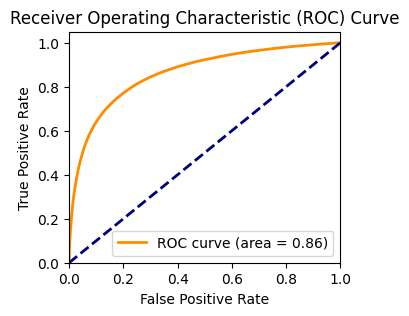

In [ ]:
model_cnn.load_state_dict(torch.load('saved_files/best_cnn_model.pth'))
plot_roc(model_cnn, test_dataloader)

In [ ]:
def similarity_cosine(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.

    Args:
        vec1 (numpy.ndarray): First vector.
        vec2 (numpy.ndarray): Second vector.

    Returns:
        float: Cosine similarity between vec1 and vec2.
    """
    cosine_similarity_arr = []
    for v1,v2 in zip(vec1, vec2):
        cosine_similarity = np.dot(v1, v2)/(np.linalg.norm(v1)* np.linalg.norm(v2))
        cosine_similarity_arr.append(cosine_similarity)
    return np.array(cosine_similarity_arr)

def load_best_model(model, path='best_model.pth'):
    """
    Load the best model from the given path.

    Args:
        model (torch.nn.Module): The model to load the state dictionary into.
        path (str): Path to the saved model state dictionary.
    """
    model.load_state_dict(torch.load(path))

def print_predictions(inx_list, label_list, c_inx_arr):
    """
    Print the correct predictions with their slopes.

    Args:
        correct_list (list): List of correct predictions.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.
        label (str): Label for the type of correct prediction (co-occurrence or no co-occurrence).
    """
    # x = np.arange(31).reshape(-1, 1)
    # lin_model = LinearRegression()
    
    for cnt, idx in enumerate(inx_list):
        # sim = similarity_cosine(encoding_dat[idx[0]][0].reshape(-1, 1), encoding_dat[idx[1]][0].reshape(-1, 1))
        # print(sim.shape)
        # lin_model.fit(x, sim.reshape(-1, 1))
        # slope = lin_model.coef_[0][0]
        print(c_inx_arr[idx[0]], c_inx_arr[idx[1]],  label_list[cnt])
        if cnt == 5:
            break

def flatten(xss):
    return [x for xs in xss for x in xs]

def evaluate_model_training_concept_predictions(model, dataloader, c_inx_arr):
    """
    Evaluate the model on the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.

    Returns:
        float: Validation accuracy.
        numpy.ndarray: Indices of the samples.
        numpy.ndarray: Model outputs.
        numpy.ndarray: Ground truth labels.
        numpy.ndarray: Correct predictions.
    """
    model.eval()
    correct_indices_0 = []
    correct_indices_1 = []
    correct_labels = []
    
    false_indices_0 = []
    false_indices_1 = []
    false_labels = []

    with torch.no_grad():
        for data, labels, inx_0, inx_1 in dataloader:
            
            labels = labels.float()
            outputs = model(data.float())
            predicted = (outputs > 0.5).float()
            
            pos_inx = (predicted == labels).cpu().numpy().flatten()
            neg_inx = (predicted != labels).cpu().numpy().flatten()
            
            correct_indices_0.append(inx_0[pos_inx].cpu().numpy().flatten() ) 
            correct_indices_1.append(inx_1[pos_inx].cpu().numpy().flatten() ) 

            false_indices_0.append(inx_0[neg_inx].cpu().numpy().flatten())
            false_indices_1.append(inx_1[neg_inx].cpu().numpy().flatten())

            correct_labels.extend(labels[pos_inx].cpu().numpy())
            false_labels.extend(labels[neg_inx].cpu().numpy())
            
            
    # Convert lists to numpy arrays
    # outputs_list = np.array(outputs_list).flatten()
    correct_labels = np.array(correct_labels).flatten()
    false_labels = np.array(false_labels).flatten()
    correct_indices = np.swapaxes(np.array([flatten(correct_indices_0),flatten(correct_indices_1)]),0,1)
    false_indices = np.swapaxes(np.array([flatten(false_indices_0),flatten(false_indices_1)]),0,1)


    print("False predictions:")
    print_predictions(false_indices, false_labels, c_inx_arr)

    print("\nCorrect predictions:")
    print_predictions(correct_indices, correct_labels, c_inx_arr)

def evaluate_model_novel_concept_predictions(model, dataloader, c_inx_arr):
    """
    Evaluate the model on the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        encoding_dat (numpy.ndarray): Encoded data.
        c_inx_arr (numpy.ndarray): Concept index array.

    Returns:
        float: Validation accuracy.
        numpy.ndarray: Indices of the samples.
        numpy.ndarray: Model outputs.
        numpy.ndarray: Ground truth labels.
        numpy.ndarray: Correct predictions.
    """
    model.eval()
    
    pos_indices_0 = []
    pos_indices_1 = []
    neg_indices_0 = []
    neg_indices_1 = []
    neg_labels = []
    pos_labels = []

    with torch.no_grad():
        for data, _, inx_0, inx_1 in dataloader:
                        
            
            outputs = model(data.float())
            predicted = (outputs > 0.5).float()
            
            pos_inx = (predicted == 1).cpu().numpy().flatten()
            neg_inx = (predicted == 0).cpu().numpy().flatten()
            
            pos_indices_0.append(inx_0[pos_inx].cpu().numpy().flatten() ) 
            pos_indices_1.append(inx_1[pos_inx].cpu().numpy().flatten() ) 

            neg_indices_0.append(inx_0[neg_inx].cpu().numpy().flatten())
            neg_indices_1.append(inx_1[neg_inx].cpu().numpy().flatten())

            pos_labels.extend(predicted[pos_inx].cpu().numpy())
            neg_labels.extend(predicted[neg_inx].cpu().numpy())
            
    pos_labels = np.array(pos_labels).flatten()
    neg_labels = np.array(neg_labels).flatten()
    pos_indices = np.swapaxes(np.array([flatten(pos_indices_0),flatten(pos_indices_1)]),0,1)
    neg_indices = np.swapaxes(np.array([flatten(neg_indices_0),flatten(neg_indices_1)]),0,1)
            

    print("Predictions to have no co-occurrence:")
    print_predictions(neg_indices, neg_labels, c_inx_arr)

    print("\nPredictions to have co-occurrence:")
    print_predictions(pos_indices, pos_labels, c_inx_arr)

  

In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the best model
load_best_model(model_mlp, "saved_files/best_mlp_model.pth")

# Final evaluation on the validation set
evaluate_model_training_concept_predictions(model_mlp, test_dataloader, c_inx_arr)

# Analyze predictions
# analyze_predictions(indices, outputs_list, labels_list, correct_indices, c_encoding_arr, c_inx_arr)

# Print final validation accuracy
# logging.info(f"\nValidation Accuracy: {val_accuracy:.2f}%")

False predictions:
(91640, 2)
pure_state_density_matrix shift_operator 0.0
robust_quantum_control rayleigh_scattering 1.0
quantum_light_source silicon_nitride 1.0
quantum_emulation unitary_operation 1.0
simulation_optimization photon_blockade 0.0
quantum_walk_dynamic gedanken_experiment 0.0

Correct predictions:
(324860, 2)
bound_entangled_state distributed_information_processing 0.0
choi_jamiolkowski_isomorphism interferometric_experiment 0.0
white_noise quantum_operation 1.0
dipole_transition dispersive_qubit_readout 0.0
dynamical_invariant thermal_bath 1.0
private_quantum_channel network_structure 0.0


In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the best model
load_best_model(model_mlp)

# Final evaluation on the validation set
evaluate_model_novel_concept_predictions(model_mlp, novel_dataloader, c_inx_arr)

# Analyze predictions
# analyze_novel_predictions(indices, outputs_list, predicted_list, c_encoding_arr, c_inx_arr)

# Print final validation accuracy
# logging.info(f"\nValidation Accuracy: {val_accuracy:.2f}%")

Predictions to have no co-occurrence:
(88951, 2)
quantum_field_state single_microwave_photon 0.0
neural_network_ansatz electron_quantum_dot 0.0
optimal_quantum_circuit tunneling_current 0.0
entangled_squeezed_state quantum_chaotic_behavior 0.0
geometric_quantum_computation information_capacity 0.0
pt_symmetric_phase diabatic_state 0.0

Predictions to have co-occurrence:
(39049, 2)
closed_form_formula quantum_volume 1.0
nodal_line computational_scaling 1.0
canonical_representation light_source 1.0
neutron_interferometry quantum_filter 1.0
quantum_spin_chain periodically_poled_lithium_niobate_crystal 1.0
vibrational_quantum quantum_fourier_transform 1.0


# Top words over time 

In [ ]:
loaded_w2v.wv.get_vector("localized")

array([-1.097879  , -5.6156535 , -1.4436402 , -0.7252618 , -2.8818622 ,
       -0.1355256 , -1.4049226 ,  1.0180815 , -4.0371447 , -0.5535636 ,
       -1.453959  , -3.5074546 ,  0.79714483, -5.212534  , -0.64656687,
       -0.4677894 ,  0.295492  ,  2.8346965 , -0.05180334, -0.17619444,
        2.4896472 , -5.404429  , -1.3762851 ,  1.8833808 , -0.87085915,
        3.9395306 ,  3.9103208 , -7.05772   ,  1.5609605 ,  1.0630037 ,
        0.19038764,  1.7278782 ,  4.832178  , 10.330503  , -2.061354  ,
       -0.8880872 , -2.2078934 ,  6.377774  , -1.9335837 ,  2.1906054 ,
       -3.347395  ,  1.6218128 ,  0.07956028, -2.8315358 , -0.14215828,
        0.7692266 ,  2.4328742 ,  2.4729712 ,  4.319967  , -1.3479974 ,
       -1.0945354 ,  2.4370947 ,  3.8069773 ,  3.8066788 , -0.822501  ,
        0.21370216,  3.233805  ,  1.4806731 , -2.886088  , -3.0978928 ,
        0.9960236 , -2.618193  ,  0.69192255,  5.547531  , -2.3263488 ,
       -7.104793  , -1.8278835 ,  1.1677247 , -6.2445807 ,  3.43

In [ ]:
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
from gensim.models import Word2Vec

concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
for year in np.unique(year_arr):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    try:
        vec_enc = loaded_w2v.wv.get_vector("many_body")
        sim = np.array(loaded_w2v.wv.most_similar("many_body"))
        print(year)
        for s in sim[:,0]:
            if s in concept_arr:
                print(s)
        print("\n")
    except:
        pass    

2024-07-08 11:08:42,580 - INFO - loading Word2Vec object from saved_models/model_year_1994.model
2024-07-08 11:08:42,582 - INFO - loading wv recursively from saved_models/model_year_1994.model.wv.* with mmap=None
2024-07-08 11:08:42,583 - INFO - setting ignored attribute cum_table to None
2024-07-08 11:08:42,584 - INFO - Word2Vec lifecycle event {'fname': 'saved_models/model_year_1994.model', 'datetime': '2024-07-08T11:08:42.584696', 'gensim': '4.3.2', 'python': '3.9.13 (main, Aug 25 2022, 23:26:10) \n[GCC 11.2.0]', 'platform': 'Linux-6.5.0-41-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
2024-07-08 11:08:42,590 - INFO - loading Word2Vec object from saved_models/model_year_1995.model
2024-07-08 11:08:42,594 - INFO - loading wv recursively from saved_models/model_year_1995.model.wv.* with mmap=None
2024-07-08 11:08:42,595 - INFO - setting ignored attribute cum_table to None
2024-07-08 11:08:42,603 - INFO - Word2Vec lifecycle event {'fname': 'saved_models/model_year_1995.model', 'da

In [ ]:
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
from gensim.models import Word2Vec

concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
for year in np.unique(year_arr):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    try:
        vec_enc = loaded_w2v.wv.get_vector("phase_transition")
        sim = np.array(loaded_w2v.wv.most_similar("machine_learning"))
        print(year)
        for s in sim[:,0]:
            if s in concept_arr:
                print(s)
        print("\n")
    except:
        pass

1997
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
class_function
quantum_mechanical_consideration


1998
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
class_function
quantum_mechanical_consideration
algebraic_expression


1999
personal_identification
secure_computation
private_information
quantum_bit_commitment
oblivious_transfer
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure


2000
personal_identification
secure_computation
private_information
quantum_bit_commitment
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure
boolean_value


2001
personal_identification
secure_computation
private_information
quantum_bit_commitment
quantum_mechanical_consideration
algebraic_expression
channel_code
cell_structure
boolean_value
information_theoretic_bound


2002
personal_identification
secure_computation
private_inf

In [ ]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# # Final evaluation on the validation set
# model.eval()
# correct_val = 0
# total_val = 0

# indices = []
# outputs_list = []
# correct_indices = []
# labels_list = []

# x = np.arange(31).reshape(-1, 1)
# lin_model = LinearRegression()

# with torch.no_grad():
#     for data, labels, inx in testing_dataloader:
#         data = data.view(data.size(0), -1).float()  # Flatten the input data
#         labels = labels.float()
#         outputs = model(data)
#         predicted = (outputs > 0.5).float()
#         total_val += labels.size(0)
#         correct_val += (predicted == labels).sum().item()
        
#         # Collect indices, outputs, labels, and correct predictions
#         indices.extend(inx.cpu().numpy())
#         outputs_list.extend(outputs.cpu().numpy())
#         labels_list.extend(labels.cpu().numpy())
#         correct_indices.extend((predicted == labels).cpu().numpy())
        

# # Convert lists to numpy arrays for sorting
# indices = np.array(indices)
# outputs_list = np.array(outputs_list).flatten()
# labels_list = np.array(labels_list).flatten()
# correct_indices = np.array(correct_indices).flatten()

# # Get sorted indices of the outputs
# sorted_indices = np.argsort(outputs_list)

# # Separate the indices of correct predictions into two categories
# correct_0 = []
# correct_1 = []

# for i in sorted_indices:
#     if correct_indices[i]:
#         if labels_list[i] == 0:
#             correct_0.append(indices[i])
#         else:
#             correct_1.append(indices[i])

# # Print indices of correct predictions
# print("Correct predictions to have no co-occurance:")
# for cnt,idx in enumerate(correct_0):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print("\n Correct predictions to have co-occurance:")
# for cnt,idx in enumerate(correct_1):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print(f"\nValidation Accuracy: {100 * correct_val / total_val:.2f}%")

In [ ]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# # Final evaluation on the validation set
# model.eval()
# correct_val = 0
# total_val = 0

# indices = []
# outputs_list = []
# predicted_list = []

# with torch.no_grad():
#     for data, inx in novel_dataloader:
#         data = data.view(data.size(0), -1).float()  # Flatten the input data
        
#         outputs = model(data)
#         predicted = (outputs > 0.5).float()
        
#         # Collect indices, outputs, labels, and correct predictions
#         indices.extend(inx.cpu().numpy())
#         outputs_list.extend(outputs.cpu().numpy())
#         predicted_list.extend(predicted.cpu().numpy())
        
# # Convert lists to numpy arrays for sorting
# indices = np.array(indices)
# outputs_list = np.array(outputs_list).flatten()
# predicted_list = np.array(predicted_list).flatten()


# # Get sorted indices of the outputs
# sorted_indices = np.argsort(outputs_list)

# # Separate the indices of correct predictions into two categories
# correct_0 = []
# correct_1 = []

# for i in sorted_indices:
#     if predicted_list[i]:
#         correct_1.append(indices[i])
#     else:
#         correct_0.append(indices[i])

# # Print indices of correct predictions
# print(" Predictions to have no co-occurance:")
# for cnt,idx in enumerate(correct_0):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]], np.round(slope,3))
#     if cnt ==5:
#         break

# print("\n Predictions to have co-occurance:")
# for cnt,idx in enumerate(correct_1):
#     sim = similarity_cosine(encoding_dat[idx[0]][0],encoding_dat[idx[1]][0])
#     lin_model.fit(x, sim.reshape(-1, 1))
#     slope = lin_model.coef_[0][0]
#     print(c_inx_arr[idx[0]],c_inx_arr[idx[1]],np.round(slope,3))
#     if cnt ==5:
#         break

In [ ]:
# class BaselineDataset(Dataset):
#     def __init__(self, data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
#                  input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1):
#         """
#         Dataset for time series data.

#         Args:
#             data (np.ndarray): The input data.
#             word_co_occurrences (dict): Dictionary of word co-occurrences.
#             year_arr (np.ndarray): Array of years.
#             c_inx_arr (np.ndarray): Array of concept indices.
#             input_window_size (int, optional): Size of the input window. Defaults to 5.
#             output_window_size (int, optional): Size of the output window. Defaults to 3.
#             offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
#         """
#         self.train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
#         self.label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
#                                  else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

#         self.co_occur_concept_pair_arr = self.get_co_occur_concept_pair_after_year_arr(
#             word_co_occurrences, self.label_year_range[0], self.label_year_range[-1])
#         self.c_inx_arr = c_inx_arr
#         self.input_window_size = input_window_size
#         self.output_window_size = output_window_size
#         self.offset_to_current_year = offset_to_current_year

#     def __len__(self) -> int:
#         return 64 * 5000

#     def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         return (self._get_positive_sample() if np.random.rand() < 0.5 else self._get_negative_sample())

#     def _get_positive_sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         while True:
#             sampled_pairs = np.random.choice(len(self.co_occur_concept_pair_arr), size=1)
#             c_pair = self.co_occur_concept_pair_arr[sampled_pairs][0]
#             inx_0 = np.where(self.c_inx_arr == c_pair[0])[0]
#             inx_1 = np.where(self.c_inx_arr == c_pair[1])[0]
#             if inx_0.size > 0 and inx_1.size > 0:
#                 break
#         enc_0 = self.train_window_data[inx_0][0][-1,:]
#         enc_1 = self.train_window_data[inx_1][0][-1,:]
        
#         return torch.from_numpy(enc_0), torch.from_numpy(enc_1),  torch.ones(1), torch.from_numpy(np.array([inx_0, inx_1]))

#     def _get_negative_sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         while True:
#             sampled_pair = np.random.choice(self.train_window_data.shape[0], size=2)
#             if self.c_inx_arr[sampled_pair[1]] not in word_co_occurrences[self.c_inx_arr[sampled_pair[0]]]:
#                 break
#         inx_0 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[0]])[0]
#         inx_1 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[1]])[0]
#         enc_0 = self.train_window_data[inx_0][0][-1,:]
#         enc_1 = self.train_window_data[inx_1][0][-1,:]
        
#         return torch.from_numpy(enc_0), torch.from_numpy(enc_1), torch.zeros(1), torch.from_numpy(np.array([inx_0, inx_1]))

#     def _check_indexing(self):
#         print(f"Training Window: {self._get_years_range(-self.input_window_size-self.output_window_size-self.offset_to_current_year, -self.output_window_size-self.offset_to_current_year)}")
#         print(f"Label Window: {self._get_years_range(-self.output_window_size-self.offset_to_current_year, -self.offset_to_current_year)}")

#     def _get_years_range(self, start: int, end: int) -> np.ndarray:
#         # return np.unique(saved_year_arr)[start:end]
    
#         return (np.unique(saved_year_arr)[start:] if end == -0 
#                                  else np.unique(saved_year_arr)[start:end])

#     @staticmethod
#     def get_co_occur_concept_pair_after_year_arr(word_co_occurrences: dict, first_occ_year: int, final_occ_year: int) -> np.ndarray:
        
#         co_occur_concept_pair_arr = []
#         for concept, v in word_co_occurrences.items():
#             for co_concept, years in v.items():
#                 if np.min(years) >= first_occ_year and np.max(years)<=final_occ_year:
#                     co_occur_concept_pair_arr.append([concept,co_concept])
#         return np.array(co_occur_concept_pair_arr)

        



# # Example usage:
# num_samples_per_class = 32
# num_features = 128
# seq_length = 10
# out_length = 3
# batch_size = 128

# print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
# print("Concept associted with representation", c_inx_arr.shape)
# scaler = RobustScaler()
# reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  # Shape: (10000*31, 128)
# normalized_data = scaler.fit_transform(reshaped_data)
# encoding_data = normalized_data.reshape(c_encoding_arr.shape)

# dataset_baseline = BaselineDataset(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr=np.unique(saved_year_arr), 
#                             c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3)

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset_baseline) - train_size
# train_baseline_dataset, val_baseline_dataset = random_split(dataset, [train_size, val_size])

# train_baseline_loader = DataLoader(train_baseline_dataset, batch_size=batch_size, shuffle=True)
# val_baseline_loader = DataLoader(val_baseline_dataset, batch_size=batch_size, shuffle=True)

# testing_baseline_dataset = BaselineDataset(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr=np.unique(saved_year_arr), 
#                             c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0)
# testing_baseline_dataset._check_indexing()
# testing_baseline_dataloader = DataLoader(testing_baseline_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# class CosineSimilarityModel(nn.Module):
#     def __init__(self):
#         super(CosineSimilarityModel, self).__init__()

#     def forward(self, vec1, vec2):
#         # Ensure the input vectors are of the same shape
#         assert vec1.shape == vec2.shape, "Input vectors must have the same shape"
        
#         # Compute cosine similarity
#         # cosine_similarity = F.cosine_similarity(vec1, vec2, dim=-1)
#         elementwise_product = vec1 * vec2

#         # Sum along the feature dimension (dim=1)
#         cosine_similarity = elementwise_product.sum(dim=1)
        
#         return cosine_similarity

# class CosineSimilarityClassifier(nn.Module):
#     def __init__(self):
#         super(CosineSimilarityClassifier, self).__init__()
#         self.cos_sim_model = CosineSimilarityModel()

#     def forward(self, vec1, vec2):
#         # Compute cosine similarity
#         cosine_similarity = self.cos_sim_model(vec1, vec2)
        
#         # Rescale cosine similarity from [-1, 1] to [0, 1]
#         rescaled_similarity = (cosine_similarity + 1) / 2
        
#         # Binary classification (class 1 if similarity >= 0.5, else class 0)
        
        
#         return rescaled_similarity


# model_cos = CosineSimilarityClassifier()

# all_preds = []
# all_labels = []
# all_probs = []
# all_precision = []
# all_rand_precision = []


# for cnt, (enc_0, enc_1, labels, _) in enumerate(testing_baseline_dataloader):
#     enc_0 = enc_0.float()
#     enc_1 = enc_1.float()
    
#     labels = labels.float()
    
    
#     outputs = model_cos(enc_0, enc_1).view(-1,1)

    
    
#     probs = outputs.cpu().numpy()
#     predicted = (outputs > 0.5).float()
#     precision_ = precision_score(labels,predicted)
    
#     precision_rand = precision_score(labels,np.random.randint(0,2,len(predicted)))
    
#     all_probs.extend(probs)
#     all_preds.extend(predicted.cpu().numpy())
#     all_labels.extend(labels.cpu().numpy())
#     all_precision.extend([precision_])
#     all_rand_precision.extend([precision_rand])
    
#     if cnt == 1000:
#         break

# # Convert lists to numpy arrays
# all_preds = np.array(all_preds).flatten()
# all_labels = np.array(all_labels).flatten()
# all_probs = np.array(all_probs).flatten()

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)

# # Print confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

# # Calculate ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(3.5, 3))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()